In [2]:
import pandas as pd
import numpy as np # เพิ่ม numpy เพื่อสร้างช่วงตัวเลขละเอียดๆ
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# ... (ส่วนโหลดข้อมูล X, y เหมือนเดิม) ...
data_path = 'updated_cleaned_patient_data.csv'
data = pd.read_csv(data_path)
feature_cols = [
    'FBS', 'BMI', 'Diabetes', 'age', 'hypertension',
    'vegetarian (1= yes, 0=no)', 'Exercise (min/week)',
    'Cholesterol', 'Living_Area_Code', 'Marriage_Status_Code'
]
data['text'] = data[feature_cols].astype(str).agg(' '.join, axis=1)
X = data['text']
y = data['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# --- ส่วนที่แก้ไข: ไล่เลขแบบละเอียด (Fine-grained) ---
param_grid = {
    # max_features: ไล่ตั้งแต่ 1,000 ถึง 10,000 ขยับทีละ 500 (ไม่ต้องเดา 3 ค่าแล้ว)
    'tfidf__max_features': list(range(1000, 10001, 500)), 
    
    # ngram: ไล่เช็ก 1-1, 1-2, 1-3
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    
    # min_df: ไล่เลข 1, 2, 3, 4, 5 ... ถึง 10 (ตัดคำที่พบน้อยกว่ากี่ครั้งทิ้ง)
    'tfidf__min_df': list(range(1, 11)), 
    
    # alpha: ไล่ทศนิยมละเอียด ตั้งแต่ 0.1 ถึง 5.0 แบ่งเป็น 50 ค่า (เช่น 0.1, 0.2, ... 4.9, 5.0)
    'clf__alpha': np.linspace(0.1, 5.0, 50) 
}

# คำนวณจำนวนรอบคร่าวๆ:
# features(19) * ngram(3) * min_df(10) * alpha(50) = 28,500 candidates
# Cross Validation 5 รอบ = 28,500 * 5 = 142,500 fits !! (โหดมาก)

print(f"Total combinations to test: {len(param_grid['tfidf__max_features']) * len(param_grid['tfidf__ngram_range']) * len(param_grid['tfidf__min_df']) * len(param_grid['clf__alpha'])}")
print("Starting Grid Search... (Computers fans might spin up!)")

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,  # ใช้ทุก Core เต็มที่
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n" + "="*40)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")
print("Best Parameters:")
print(grid_search.best_params_)
print("="*40 + "\n")

best_model = grid_search.best_estimator_
test_pred = best_model.predict(X_test)

print("Final Test Accuracy:", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred))

Total combinations to test: 28500
Starting Grid Search... (Computers fans might spin up!)
Fitting 5 folds for each of 28500 candidates, totalling 142500 fits

Best CV Accuracy: 0.7600
Best Parameters:
{'clf__alpha': np.float64(0.1), 'tfidf__max_features': 1000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}

Final Test Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       156
           1       0.64      0.20      0.31        44

    accuracy                           0.80       200
   macro avg       0.73      0.59      0.60       200
weighted avg       0.77      0.80      0.76       200



In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

# 1. โหลดข้อมูล
data_path = 'updated_cleaned_patient_data.csv'
data = pd.read_csv(data_path)

# 2. เลือกฟีเจอร์
feature_cols = [
    'FBS', 'BMI', 'Diabetes', 'age', 'hypertension',
    'vegetarian (1= yes, 0=no)', 'Exercise (min/week)',
    'Cholesterol', 'Living_Area_Code', 'Marriage_Status_Code'
]

X = data[feature_cols]
y = data['stroke']

# แบ่งข้อมูล (stratify=y เพื่อรักษาสัดส่วนคนป่วย)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. สร้าง Pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()),                
    ('clf', GaussianNB())                        
])

# 4. กำหนดค่าที่ต้องการจูน
param_grid = {
    'clf__var_smoothing': np.logspace(0, -9, num=100)
}

# 5. เริ่ม Grid Search
print("Starting Grid Search with GaussianNB...")
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)

# 6. แสดงผลลัพธ์
print("\n" + "="*40)
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")
print("Best Parameters:")
print(grid_search.best_params_)
print("="*40 + "\n")

# ดึงโมเดลที่ดีที่สุดมาใช้
best_model = grid_search.best_estimator_

# ทำนายผลทั้ง Train และ Test
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

# --- ส่วนที่เพิ่มเข้ามา ---
print(f"Train Accuracy: {accuracy_score(y_train, train_pred):.4f}")
# ----------------------
print(f"Test Accuracy : {accuracy_score(y_test, test_pred):.4f}")

print("\nClassification Report (Test Set):\n")
print(classification_report(y_test, test_pred))

Starting Grid Search with GaussianNB...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best CV F1-Score: 0.5254
Best Parameters:
{'clf__var_smoothing': np.float64(0.04328761281083057)}

Train Accuracy: 0.7638
Test Accuracy : 0.8100

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       150
           1       0.62      0.62      0.62        50

    accuracy                           0.81       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.81      0.81      0.81       200



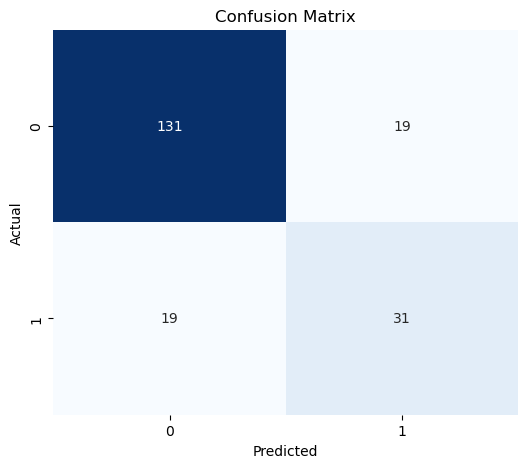

In [11]:
# --- ส่วนที่เขียนต่อ (Visualization) ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1. Confusion Matrix (ทายถูก/ผิด)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
